In [1]:
import rockhound as rh
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import pandas as pd
import pygmt
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
from rockhound.slab2 import ZONES

# Fetch all Slab2 subduction zones and add them inside a list
#we skip halmahera because it is not connected to a present-day subduciton zone
subduction_zones = []
for zone in ZONES:
    if zone == 'halmahera':
        continue
    #print(zone)
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])

In [3]:
# Get min and max values of the subducting plates' depths
vmax = max([grid.dip.actual_range[1] for grid in subduction_zones])
vmin = min([grid.dip.actual_range[0] for grid in subduction_zones])

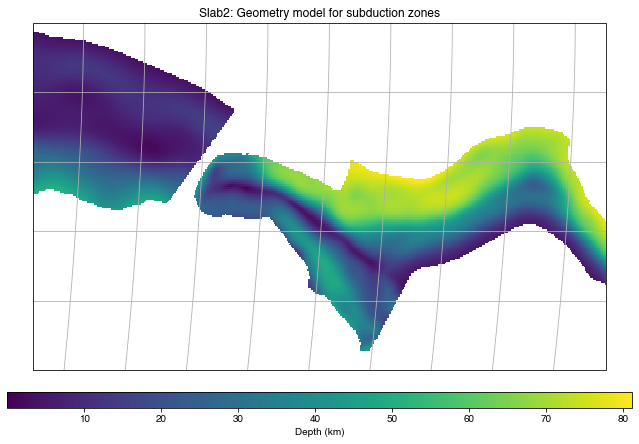

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8),
                     subplot_kw={'projection': ccrs.Robinson()})
ax.set_rasterization_zorder(2)
date_line_wrapper = pygplates.DateLineWrapper(0)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
#ax = plt.axes(projection=ccrs.Robinson())
for grid in subduction_zones:
    pc = grid.dip.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax,
        zorder=1    )
    

ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (km)',
    pad=0.05,
    aspect=40,
    shrink=0.7,
    orientation="horizontal",
)
ax.set_global()
gl = ax.gridlines()
#gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
#gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator(np.arange(-180,182,2))
gl.ylocator = mticker.FixedLocator(np.arange(-90,92,2))
#plt.xlim(137,155)
#plt.ylim(-10,0)
ax.set_extent([137, 155, -10, 0],
              crs=ccrs.PlateCarree())


In [5]:
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat)))
#grid = grid * -0.001
pc = grid.dip.plot.pcolormesh(ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax)


In [6]:
# now we want to make cross sections, but we have to load in individual grids (the global one
#isn't evenly sampled)
#our list of filenames are:
print(ZONES.keys())


dict_keys(['alaska', 'calabria', 'caribbean', 'cascadia', 'central_america', 'cotabalo', 'halmahera', 'hellenic', 'himalaya', 'hindu_kush', 'izu_bonin', 'kamchatka', 'kermadec', 'makran', 'manila_trench', 'muertos_trough', 'new_guinea', 'pamir', 'philippines', 'puysegur', 'ryukyu', 'scotia_sea', 'solomon_islands', 'south_america', 'sulawesi', 'sumatra_java', 'vanuatu'])


In [7]:
#Load sample grid and point datasets, use rockhound
SAM = rh.fetch_slab2('south_america')
IZB = rh.fetch_slab2('izu_bonin')
#get depth
grid = SAM.dip

In [8]:
#here we define our cross section, we have 40 points, some will returns nans though
lat = [-25]*40
lon = np.linspace(280, 300, 40)
#lat = [30]*40
#lon = np.linspace(160, 120, 40)
#pygmt track needs lon/lat as separate columns in pandas dataframe
d = { 'lon': lon,'lat': lat}
points = pd.DataFrame(data=d)

# Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')

#define line for cross section
cross_section_points = []
cross_section_points.append((min(lat),min(lon)))
cross_section_points.append((max(lat),max(lon)))
cross_section_line = pygplates.PolylineOnSphere(cross_section_points)
cross_section_line = cross_section_line.to_tessellated(np.radians(0.1))

In [9]:
#the df will contain some NaNs that we want to filtertrack
track_dropna = track.dropna()

In [10]:
#use haversine formula to convert to km
#get distance, equally spaced so we can define at the start
lat1 = track_dropna['lat'].values[0]
lat2 = track_dropna['lat'].values[1]
lon1 = track_dropna['lon'].values[0]
lon2 = track_dropna['lon'].values[1]
# convert decimal degrees to radians 
lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

# haversine formula 
dlon = lon2 - lon1
dlat = lat2 - lat1 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

c = 2 * np.arcsin(np.sqrt(a)) 
r = 6371 # Radius of earth in kilometers. Use 3956 for miles

distance = c*r

#get the incremental range
distance_range = []
for i in range(track_dropna['depth'].count()):

    distance_range.append(i*distance)


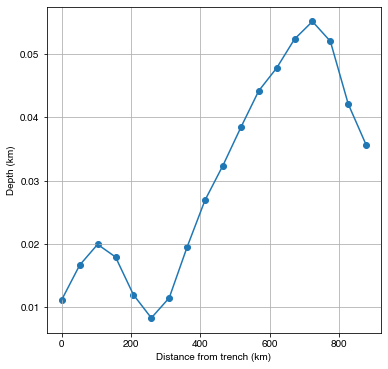

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(np.asarray(distance_range),
            track_dropna['depth'].values*.001)
plt.plot(np.asarray(distance_range),
            track_dropna['depth'].values*.001)
#plt.gca().set_xlim([0, 400])
#plt.gca().set_ylim([-200,0])
plt.xlabel('Distance from trench (km)')
plt.ylabel('Depth (km)')
plt.grid()

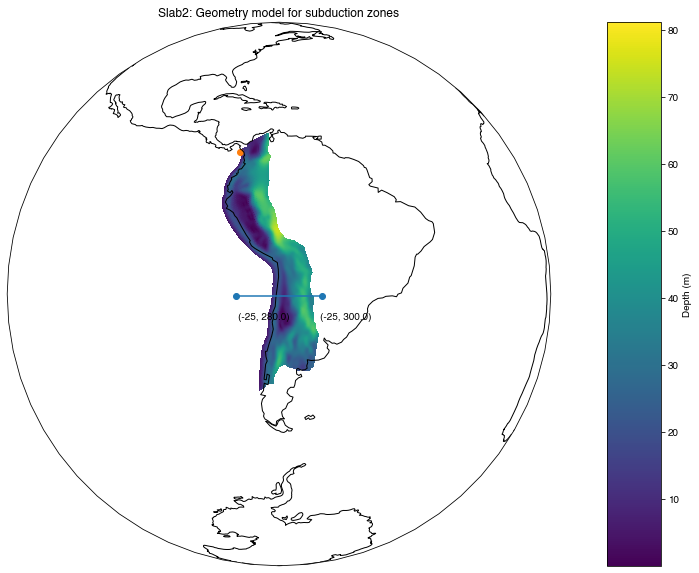

In [12]:
#plot cross section map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat)))
#grid = grid * -0.001
pc = grid.plot.pcolormesh(ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax)
ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (m)',
    pad=0.05,
    aspect=10,
    shrink=1,
    orientation="vertical",
)

ax.scatter([min(lon), max(lon)],
           [min(lat), max(lat)],transform=ccrs.PlateCarree())
ax.plot([min(lon), max(lon)],
        [min(lat), max(lat)],transform=ccrs.PlateCarree())
ax.scatter(281.624031,6.773492,transform=ccrs.PlateCarree())
point_one = (min(lat), min(lon))
point_two = (max(lat), max(lon))
ax.text(min(lon), min(lat)-5, str(point_one),transform=ccrs.PlateCarree())
ax.text(max(lon), max(lat)-5, str(point_two),transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.grid()
plt.show()

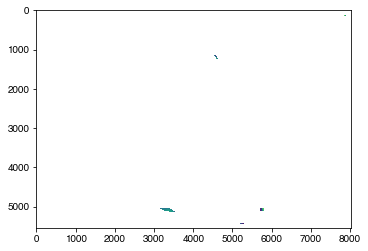

In [13]:
plt.imshow(global_sub_zones.dip.values)

In [14]:
np.nanstd(grid1.values)

NameError: name 'grid1' is not defined

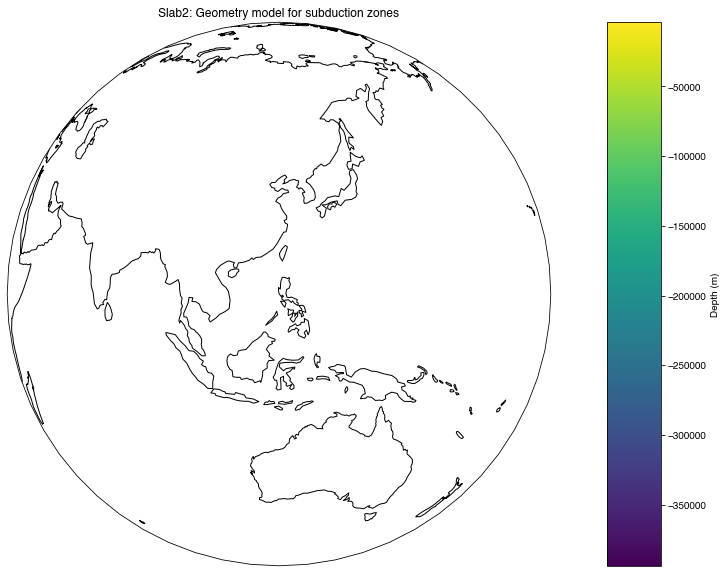

In [15]:
PHI = rh.fetch_slab2('central_america')
grid1 = PHI.depth
#plot cross section map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=120, central_latitude=15))
#grid = grid * -0.001
pc = grid1.plot.pcolormesh(ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False)
ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (m)',
    pad=0.05,
    aspect=10,
    shrink=1,
    orientation="vertical",
)
#ax.set_global()
ax.coastlines()

/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


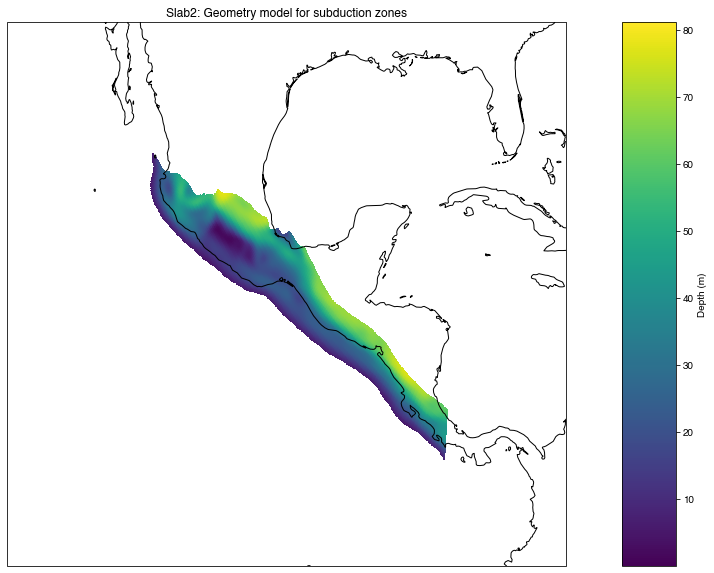

In [18]:
PHI = rh.fetch_slab2('central_america')
grid1 = PHI.dip
#plot cross section map
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=300, central_latitude=15))
#grid = grid * -0.001
pc = grid1.plot.pcolormesh(ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax)
ax.set_title("Slab2: Geometry model for subduction zones")
plt.colorbar(
    pc,
    ax=ax,
    label='Depth (m)',
    pad=0.05,
    aspect=10,
    shrink=1,
    orientation="vertical",
)
#ax.set_global()
ax.coastlines()

In [ ]:
plt.figure(figsize=(16,8))
plt.pcolormesh(global_sub_zones.dip.values)
plt.colorbar()

In [9]:
lats = np.arange(-90,90.05,0.05)
lons = np.arange(0,360.1,0.1)
lons_mesh,lats_mesh = np.meshgrid(lons,lats)
nans = np.zeros_like(lons_mesh)
nans[:] = np.nan

In [10]:
#make array for exporting
global_array = xr.Dataset(
                data_vars={'depth': (('latitude', 'longitude'), nans),
                           'dip': (('latitude', 'longitude'), nans),
                           'strike': (('latitude', 'longitude'), nans),
                           'thickness': (('latitude', 'longitude'), nans),
                           'depth_uncertainty': (('latitude', 'longitude'), nans)},
                coords={'latitude': lats,
                        'longitude': lons})
#merge
global_sub_zones = xr.merge([global_sub_zones, global_array])


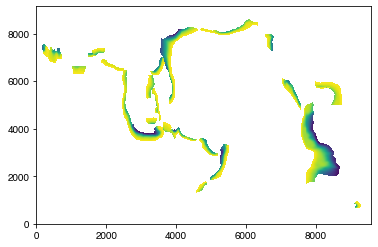

In [11]:
plt.pcolormesh(global_sub_zones.depth)

In [13]:
savefile = '/Users/andrew/Documents/Data/Merdith_sub_zones/Slab2point0/'
global_sub_zones.to_netcdf('%ssub_zones_Slab2_no_halmahera.nc' % savefile)